# Burger Master
El Burger Master es un evento creado en el 2016 por el influenciador Tulio Zuluaga, más conocido en redes como Tulio recomienda, el cual busca que por una semana las hamburgueserías de cada ciudad ofrezcan su mejor producto a un precio reducido. 

El evento ha venido creciendo y en el 2022 se extendió por 21 ciudades de Colombia para las cuales se estimó que se vendieron más de dos millones de hamburguesas. El objetivo del presente notebook es que visualice la ubicación de la mayoría de los restaurantes que compitieron en la ciudad de Bogotá y aplique su conocimiento en el algoritmo de Mixturas Gaussiana para agrupar los restaurantes según su ubicación.

In [24]:
# Estos paquetes serán de utilidad para su tarea
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import seaborn as sns
import folium
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn import preprocessing
from sklearn.metrics import silhouette_score

1. En primer lugar debe cargar los datos de la ciudad de Bogotá.

In [2]:
restaurantes = pd.read_excel("burgar_master.xlsx")
restaurantes.head()

,Restaurante,Dirección,Descripción,Latitud,Longitud
0,MAIKKI,Cra 75 # 24D – 48,"<p>MAIKKI MACUIRA: Cama de chicharrón soplado,...",4.668833,-74.116828
1,MAIKKI,Calle 119 # 11A – 24,"<p>MAIKKI MACUIRA: Cama de chicharrón soplado,...",4.698395,-74.036585
2,MAIKKI,Cra 47A # 98 – 47,"<p>MAIKKI MACUIRA: Cama de chicharrón soplado,...",4.686401,-74.060144
3,FRENCHEESE,Calle 51 #22-55,"<p>Presentamos «La French Master», inspirada e...",4.639514,-74.073545
4,FRENCHEESE,Calle 80 #14-41,"<p>Presentamos «La French Master», inspirada e...",4.666147,-74.056758


2. Visualice la ubicación de cada restaurante en un mapa intercativo. Añada un marcador para cada restaurante y la posibilidad de encontrar la descripción de la burger ofrecida en un pop-up.

In [3]:
m = folium.Map(location = [4.624335, -74.063644],  zoom_start = 12)
# Vamos a ponerle información encima
lugares = folium.FeatureGroup(name = "Restaurantes")
for i in range(restaurantes.shape[0]):
    html = "<b>" + restaurantes.loc[i, "Restaurante"] + "</b> " + restaurantes.loc[i, "Descripción"]
    iframe = folium.IFrame(html, width = 250, height = 100)
    popup = folium.Popup(iframe, max_width = 250)
    lugares.add_child(folium.CircleMarker(location = [restaurantes.Latitud[i], restaurantes.Longitud[i]], 
        radius = 1,
        popup = popup, 
        tooltip = None,
        fill = True,
        color = "Red",
        fill_opacity = 1.0)).add_to(m)
m

3. Aplique el modelo de Mixturas Gaussianas sobre los datos y escoja el número óptimo de clústeres. Justifique su respuesta. Además mencione qué parámetro de covarianza usó y explique el porqué.

In [4]:
X = restaurantes[["Latitud", "Longitud"]]
X = preprocessing.scale(X)

modelos = {}
metricas = pd.DataFrame()

for k in tqdm(range(2, 21)):
    # Ajustar el modelo
    # Como los resultados son aleatorios, vamos a correr el modelo 10 veces para cada k. Para cada k,
    # se escoge la mejor.
    modelo = GaussianMixture(n_components = k, covariance_type = 'full', n_init = 10, random_state = 666).fit(X)
    # Crear las clasificaciones
    clusteres = modelo.predict(X)
    probabilidades = modelo.predict_proba(X)
    # Guardamos el modelo y sus resultados
    modelos[k] = {"modelo": modelo, "clusteres": clusteres, "probabilidades": probabilidades}
    # Diferentes métricas para evaluar el modelo
    aic = modelo.aic(X)
    bic = modelo.bic(X)
    log_verosimilitud = modelo.score(X)
    silhouette = silhouette_score(X, clusteres)
    fila = pd.DataFrame([(k, aic, bic, log_verosimilitud, silhouette)], 
        columns = ["K", "AIC", "BIC", "Log verosimilitud", "Silhouette"])
    metricas = metricas.append(fila).reset_index(drop = True)  

100%|██████████| 19/19 [00:05<00:00,  3.18it/s]


En este caso usamos el parámetro 'full' para el tipo de covarianza usado. Esto implica que cada segmento tendrá su propia matriz de covarianza. Esto permite tener mayor libertad al modelo para que cada segmento pueda tener una forma diferente la cual se ajuste de la mejor manera a los datos observados. Dado que tenemos pocas observaciones, no es un problema computacional considerable haber escogido este parámetro.

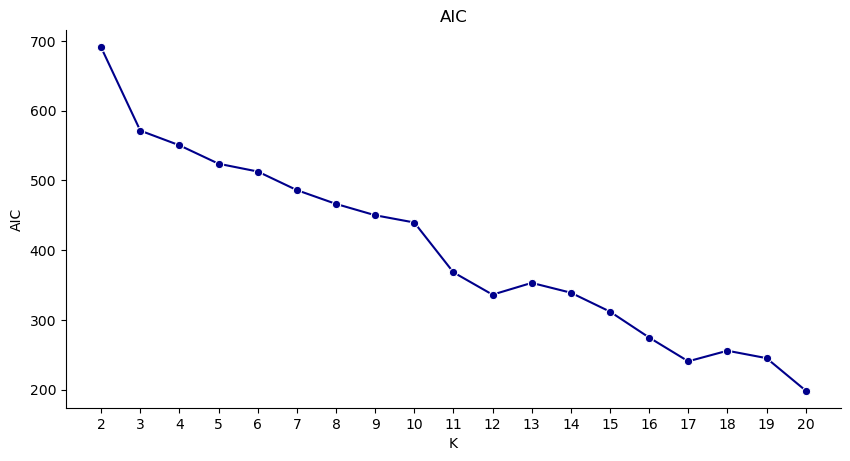

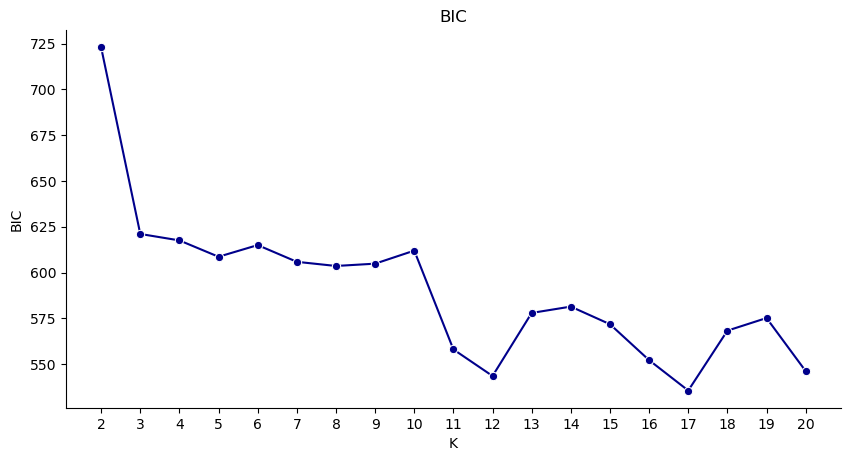

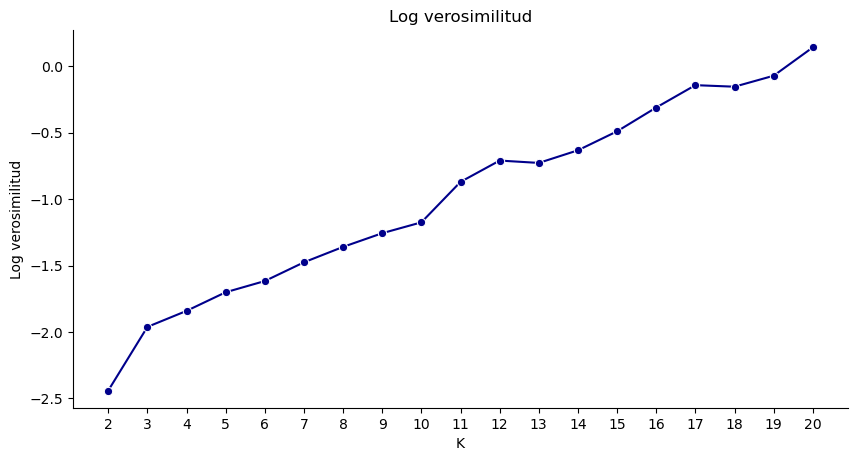

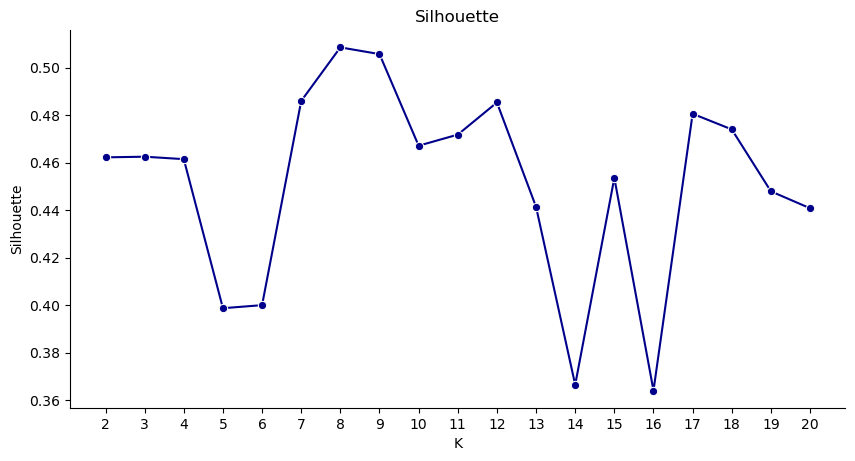

In [5]:
for var in ["AIC", "BIC", "Log verosimilitud", "Silhouette"]:
    fig, ax = plt.subplots(figsize = (10, 5), dpi = 100)
    plt.title(var)
    sns.lineplot(x = "K", y = var, data = metricas, marker = "o", color = "darkblue", ax = ax)
    ax.xaxis.set_major_locator(plt.MaxNLocator(20, integer = True))
    sns.despine()

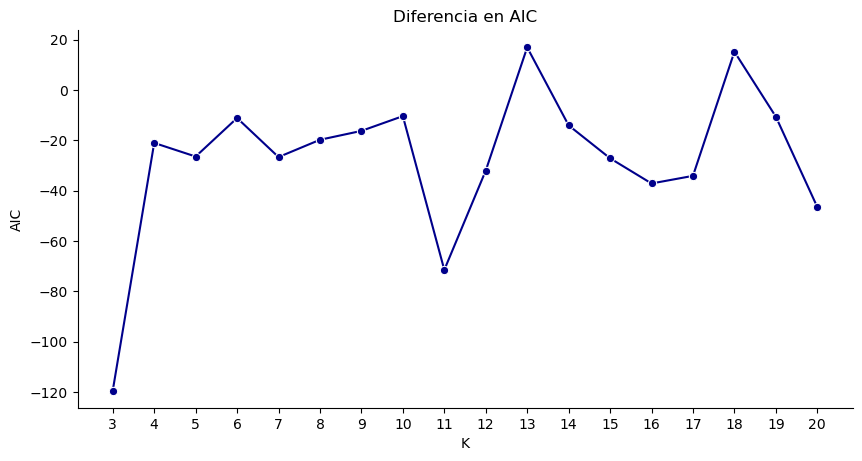

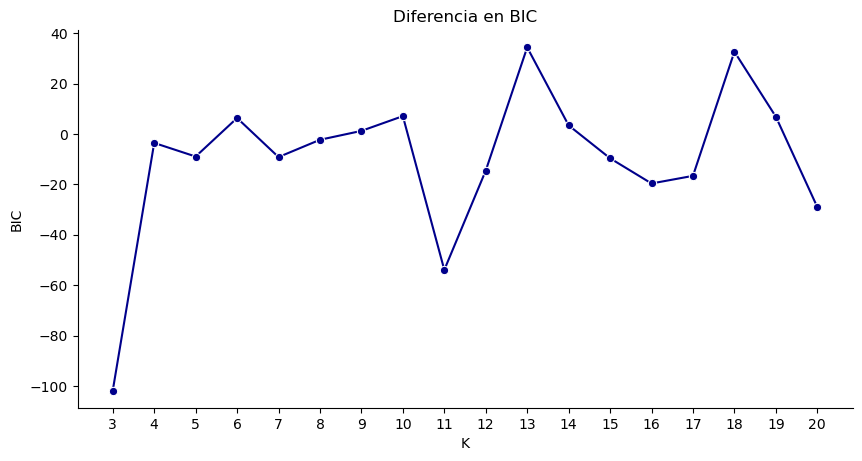

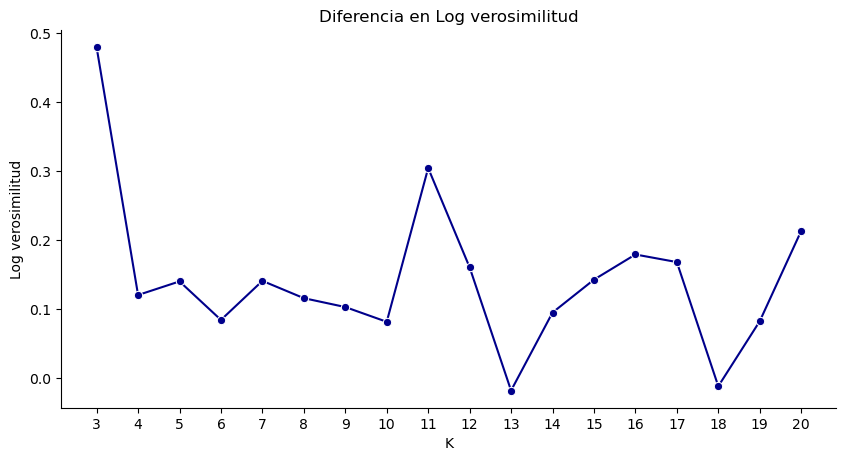

In [6]:
for var in ["AIC", "BIC", "Log verosimilitud"]:
    fig, ax = plt.subplots(figsize = (10, 5), dpi = 100)
    plt.title("Diferencia en " + var)
    sns.lineplot(x = "K", y = metricas.diff()[var], data = metricas, marker = "o", color = "darkblue", ax = ax)
    ax.xaxis.set_major_locator(plt.MaxNLocator(20, integer = True))
    sns.despine()

Visualizamos diferentes métricas de desempeño. En general se prefiere el uso del BIC sobre AIC, sin embargo se reportan ambos porque en gran parte de la literatura se reporta que llegan a resultados similares. Naturalmente sabemos que el BIC, el AIC y el negativo de la Log-Verosimilitud son decrecientes con el número de clústeres, por tal motivo, se analiza el gradiente para estas métricas para evaluar a partir de qué incremento en K la mejoría en el modelo es marginal. Para estos casos, las tres métricas muestran que el número de clústeres óptimo es 3-4. 

Por otro lado, el índice de Silhouette no concuerda con los resultados de las anteriores métricas. Aunque no tiene valores muy superiores a 0.5, el K óptimo según este criterio es 8. Por ende, se van a mostrar los resultados de la segmentación de K 3, 4 y 8 y se tomará una decisión a partir de un criterio gráfico.

In [7]:
def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Dibuja un elipse dado la media y varianza"""
    ax = ax or plt.gca()
    
    # Convierte las covarianzas
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Dibuja el elipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle,  color = "darkblue", **kwargs))
        
def plot_gmm(modelo, predicciones, X, label=True, ax=None):
    ax = ax or plt.gca()
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=predicciones, s=40, cmap='Spectral', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / modelo.weights_.max()
    for pos, covar, w in zip(modelo.means_, modelo.covariances_, modelo.weights_):            
        draw_ellipse(pos, covar, alpha=w * w_factor)

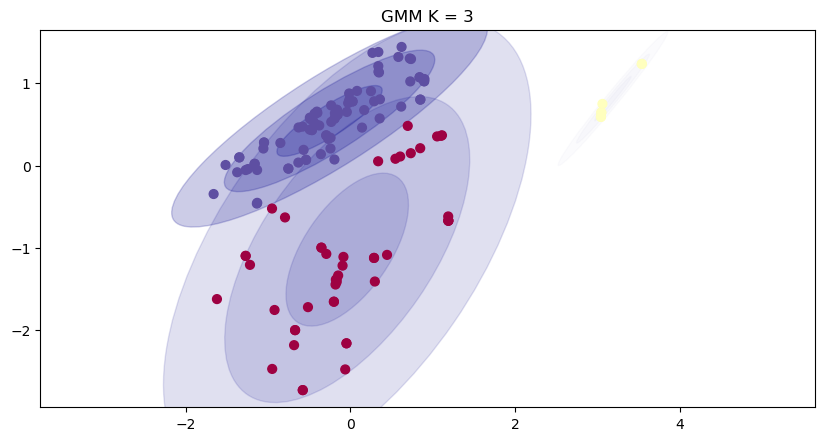

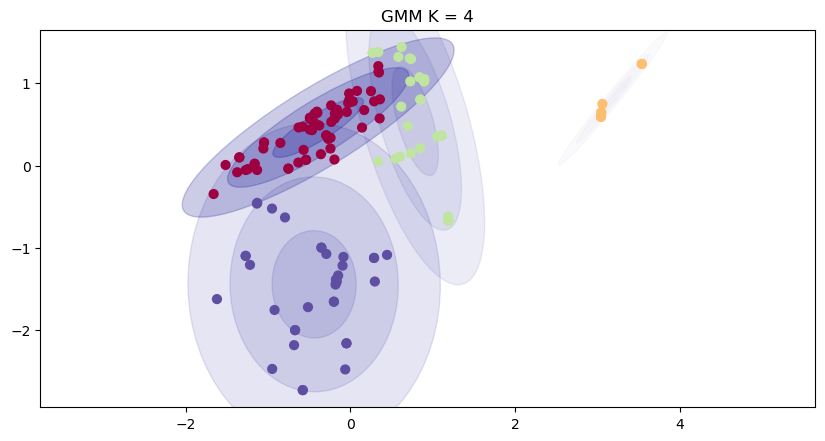

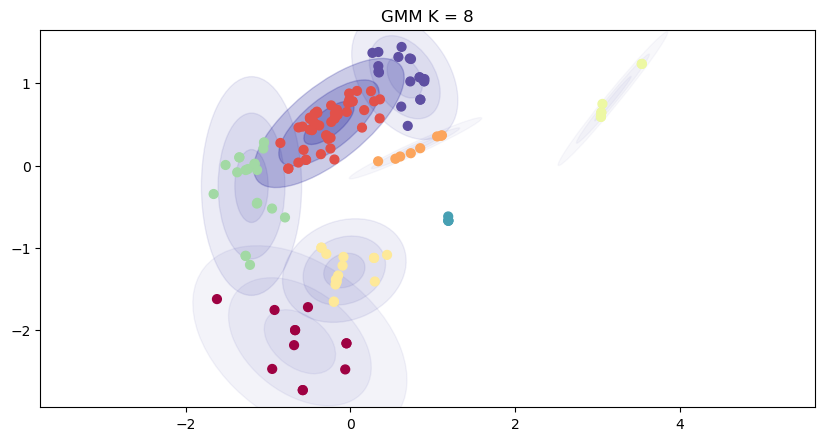

In [8]:
for k in [3, 4, 8]:
    fig, ax = plt.subplots(figsize = (10, 5), dpi = 100)
    plt.title("GMM K = " + str(k))
    plot_gmm(X = X, modelo = modelos[k]["modelo"], predicciones = modelos[k]["clusteres"])

Visualización sin datos escalados

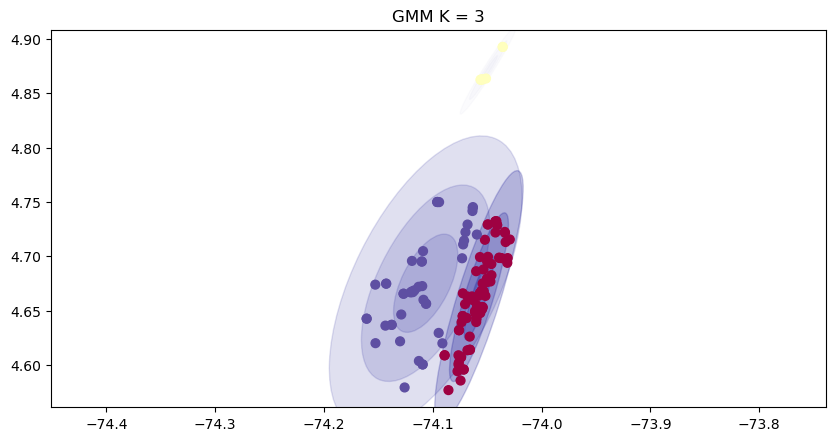

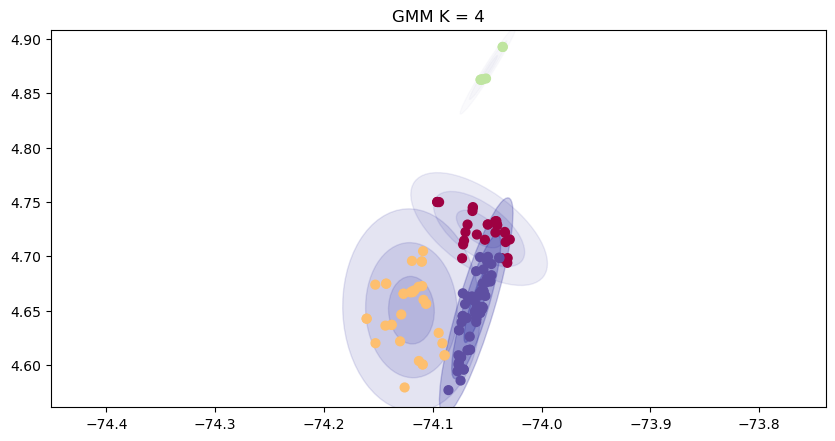

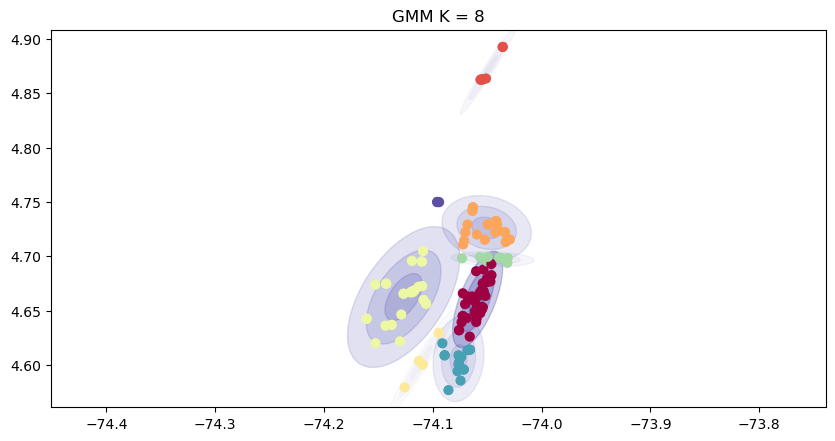

In [9]:
coordenadas = restaurantes[["Longitud", "Latitud"]].values
for k in [3, 4, 8]:
    fig, ax = plt.subplots(figsize = (10, 5), dpi = 100)
    plt.title("GMM K = " + str(k))
    modelo = GaussianMixture(n_components = k, covariance_type = 'full', n_init = 10, random_state = 666).fit(coordenadas)
    predicciones = modelo.predict(coordenadas)
    plot_gmm(X = coordenadas, modelo = modelo, predicciones = predicciones)

Las visualizaciones nos sirvieron para descartar la solución de K = 8. Para K = 3 y K = 4 existe cierta consistencia de clusteres donde claramente se ven agrupaciones para restaurantes fuera de Bogotá, en Chía, como el segmento más al norte. Luego se muestran dos segmentos alargados que conformarían los restaurantes del oriente y el occidente de Bogotá separados por la autopista. 

En general, ambas segmentaciones son muy similares (K = 3 y K = 4). La diferencia vendría con K = 4, en donde se separa como un nuevo clúster los restaurantes ubicados en la Zona más al norte de Bogotá al rededor de las localidades de Usaquen y Suba. Cualquiera de estas dos agrupaciones podría resultar válida.

4. Visualice la segmentación de los restaurantes en un mapa intercativo.

In [13]:
restaurantes["K3"] = modelos[3]["clusteres"]
restaurantes["K4"] = modelos[4]["clusteres"]

In [40]:
m = folium.Map(location = [4.624335, -74.063644],  zoom_start = 10)
# Vamos a ponerle información encima
lugares = folium.FeatureGroup(name = "Restaurantes")
for i in range(restaurantes.shape[0]):
    html = "<b>" + restaurantes.loc[i, "Restaurante"] + "</b> " + restaurantes.loc[i, "Descripción"]
    iframe = folium.IFrame(html, width = 250, height = 100)
    popup = folium.Popup(iframe, max_width = 250)
    lugares.add_child(folium.CircleMarker(location = [restaurantes.Latitud[i], restaurantes.Longitud[i]], 
        radius = 1,
        popup = popup, 
        tooltip = None,
        fill = True,
        color = str(np.where(restaurantes.K3[i] == 0, "Blue", np.where(restaurantes.K3[i] == 1, "Purple", np.where(restaurantes.K3[i] == 2, "Green", "Red")))),
        fill_opacity = 1.0)).add_to(m)
m

In [39]:
m = folium.Map(location = [4.624335, -74.063644],  zoom_start = 10)
# Vamos a ponerle información encima
lugares = folium.FeatureGroup(name = "Restaurantes")
for i in range(restaurantes.shape[0]):
    html = "<b>" + restaurantes.loc[i, "Restaurante"] + "</b> " + restaurantes.loc[i, "Descripción"]
    iframe = folium.IFrame(html, width = 250, height = 100)
    popup = folium.Popup(iframe, max_width = 250)
    lugares.add_child(folium.CircleMarker(location = [restaurantes.Latitud[i], restaurantes.Longitud[i]], 
        radius = 1,
        popup = popup, 
        tooltip = None,
        fill = True,
        color = str(np.where(restaurantes.K4[i] == 0, "Blue", np.where(restaurantes.K4[i] == 1, "Purple", np.where(restaurantes.K4[i] == 2, "Green", "Red")))),
        fill_opacity = 1.0)).add_to(m)
m

5. Compare los resultados obtenidos por el modelo escogido con un modelo de K Medias

In [29]:
modelos2 = {}
metricas2 = pd.DataFrame()

for k in tqdm(range(2, 21)):
    # Ajustar el modelo
    # Como los resultados son aleatorios, vamos a correr el modelo 10 veces para cada k. Para cada k,
    # se escoge la mejor.
    modelo = KMeans(n_clusters = k, n_init = 10, random_state = 666).fit(X)
    # Crear las clasificaciones
    clusteres = modelo.predict(X)

    # Guardamos el modelo y sus resultados
    modelos2[k] = {"modelo": modelo, "clusteres": clusteres}
    # Diferentes métricas para evaluar el modelo
    log_verosimilitud = modelo.score(X)
    silhouette = silhouette_score(X, clusteres)
    fila = pd.DataFrame([(k, log_verosimilitud, silhouette)], 
        columns = ["K", "Log verosimilitud", "Silhouette"])
    metricas2 = metricas2.append(fila).reset_index(drop = True)  

100%|██████████| 19/19 [00:02<00:00,  8.74it/s]


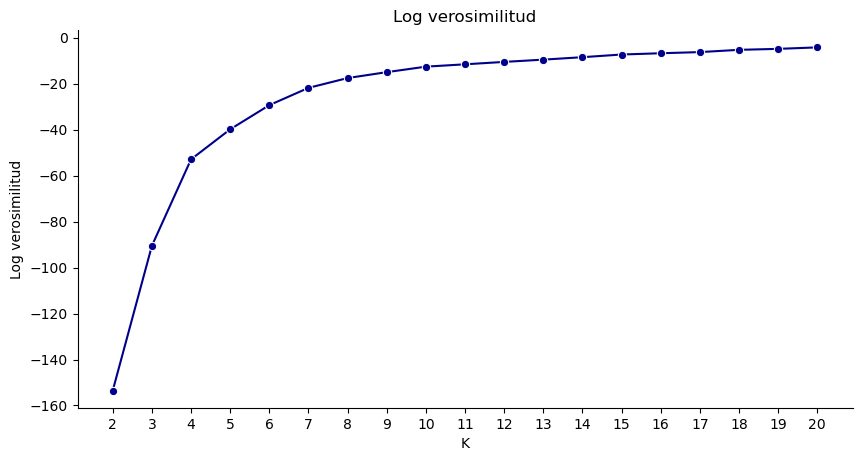

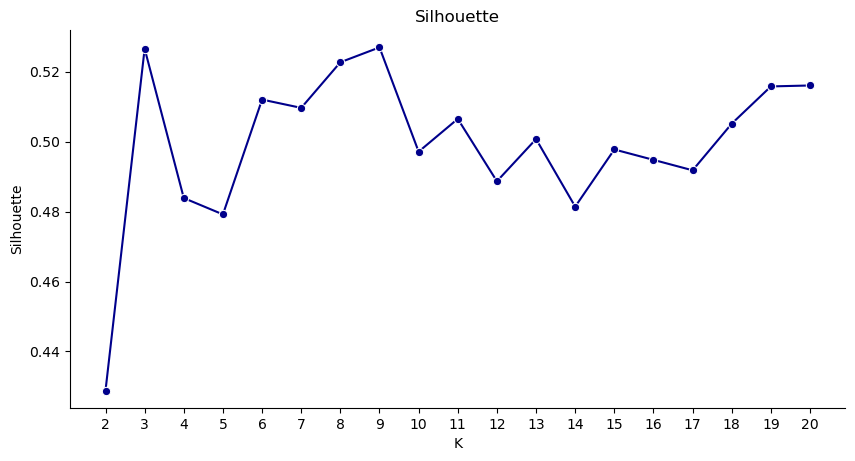

In [31]:
for var in ["Log verosimilitud", "Silhouette"]:
    fig, ax = plt.subplots(figsize = (10, 5), dpi = 100)
    plt.title(var)
    sns.lineplot(x = "K", y = var, data = metricas2, marker = "o", color = "darkblue", ax = ax)
    ax.xaxis.set_major_locator(plt.MaxNLocator(20, integer = True))
    sns.despine()

Nuevamente escogeremos K = 3 y K = 4

In [34]:
restaurantes["K3_medias"] = modelos2[3]["clusteres"]
restaurantes["K4_medias"] = modelos2[4]["clusteres"]

In [37]:
m = folium.Map(location = [4.624335, -74.063644],  zoom_start = 10)
# Vamos a ponerle información encima
lugares = folium.FeatureGroup(name = "Restaurantes")
for i in range(restaurantes.shape[0]):
    html = "<b>" + restaurantes.loc[i, "Restaurante"] + "</b> " + restaurantes.loc[i, "Descripción"]
    iframe = folium.IFrame(html, width = 250, height = 100)
    popup = folium.Popup(iframe, max_width = 250)
    lugares.add_child(folium.CircleMarker(location = [restaurantes.Latitud[i], restaurantes.Longitud[i]], 
        radius = 1,
        popup = popup, 
        tooltip = None,
        fill = True,
        color = str(np.where(restaurantes.K3_medias[i] == 0, "Blue", np.where(restaurantes.K3_medias[i] == 1, "Purple", np.where(restaurantes.K3_medias[i] == 2, "Green", "Red")))),
        fill_opacity = 1.0)).add_to(m)
m

In [38]:
m = folium.Map(location = [4.624335, -74.063644],  zoom_start = 10)
# Vamos a ponerle información encima
lugares = folium.FeatureGroup(name = "Restaurantes")
for i in range(restaurantes.shape[0]):
    html = "<b>" + restaurantes.loc[i, "Restaurante"] + "</b> " + restaurantes.loc[i, "Descripción"]
    iframe = folium.IFrame(html, width = 250, height = 100)
    popup = folium.Popup(iframe, max_width = 250)
    lugares.add_child(folium.CircleMarker(location = [restaurantes.Latitud[i], restaurantes.Longitud[i]], 
        radius = 1,
        popup = popup, 
        tooltip = None,
        fill = True,
        color = str(np.where(restaurantes.K4_medias[i] == 0, "Blue", np.where(restaurantes.K4_medias[i] == 1, "Purple", np.where(restaurantes.K4_medias[i] == 2, "Green", "Red")))),
        fill_opacity = 1.0)).add_to(m)
m

Para K = 3, el clúster resultante de K Medias no divide a Bogotá entre restaurantes a la izquierda y derecha de la autopista. Por el contrario, incluye los restaurantes por encima de la Calle 100 en el segmento del Oriente. 

Para K = 4, el clúster resultante de K Medias es bastante similar al de Mixturas Gaussianas, solo que el clúster del norte de Bogotá comienza 20 cuadras más al sur en el primero en comparación al segundo. Para el caso de Mixturas Gaussianas se ve que los segmentos resultantes son más alargados y de forma elipsoide, a diferencia de los segmentos de K Medias en donde tienen una forma más circular.

Una ventaja del modelo de Mixturas Gaussianas frente a K Medias es que la asignación de los segmentos no es total sino probabilística, por ende puede capturar que cada punto es una combinación de clústeres. Esto cobra más relevancia en aquellos puntos que se encuentran en las fronteras visibles entre los diferentes segmentos, pues tiene más sentido estadístico expresarlos como una hibridación entre grupos.